# Load data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer, Dense, Embedding, Dropout


RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

In [ ]:
def text_normalize(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r'[^\w\s\n]', '', text)
    text = text.replace('\n\n', '\n')
    text = '\n'.join(['<start> ' + line + ' <end>' for line in text.split('\n') if line != '' and len(line.split()) == 5])

    return text

In [ ]:
BATCH_SIZE = 32
MAX_SEQ_LEN = 7
VOCAB_SIZE = 5000

In [ ]:
DATASET_PATH = './data-set1.csv'

df = pd.read_csv(DATASET_PATH, index_col=0)
df['poem_content'] = df['poem_content'].apply(lambda p: text_normalize(p))
# df['poem_content'] = df['poem_content'].astype(str).apply(lambda p: text_normalize(p))
corpus = df['poem_content'].to_numpy()

X = []
y = []
for idx, row in df.iterrows():
    lines = row['poem_content'].split('\n')
    lines = [line for line in lines if line != '']
    for idx in range(0, len(lines) - 1):
        input_sentence = lines[idx]
        output_sentence = lines[idx+1]

        X.append(input_sentence)
        y.append(output_sentence)

In [ ]:
for idx in range(len(X))[:10]:
    print(f'Input: {X[idx]} => {y[idx]}')

Input: <start> hầu hết các đồ vật <end> => <start> ta muốn đều đắt tiền <end>
Input: <start> ta muốn đều đắt tiền <end> => <start> một khi không có được <end>
Input: <start> một khi không có được <end> => <start> ta cảm thấy buồn phiền <end>
Input: <start> ta cảm thấy buồn phiền <end> => <start> trong khi cái thực sự <end>
Input: <start> trong khi cái thực sự <end> => <start> làm ta vui ở đời <end>
Input: <start> làm ta vui ở đời <end> => <start> hoàn toàn không tốn kém <end>
Input: <start> hoàn toàn không tốn kém <end> => <start> là tình yêu tiếng cười <end>
Input: <start> hiện tại anh đang sống <end> => <start> không được để phí hoài <end>
Input: <start> không được để phí hoài <end> => <start> vì nỗi buồn quá khứ <end>
Input: <start> vì nỗi buồn quá khứ <end> => <start> và sợ hãi tương lai <end>


In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='', oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

VOCAB_SIZE = len(tokenizer.word_index) + 1

In [ ]:
def prepare_output_sequences(y_sequences):
    y_inputs = pad_sequences([y_seq[:-1] for y_seq in y_sequences], maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')
    y_outputs = pad_sequences([y_seq[1:] for y_seq in y_sequences], maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')

    return y_inputs, y_outputs

X_sequences = tokenizer.texts_to_sequences(X)
X_padded_sequences = pad_sequences(X_sequences, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')

y_sequences = tokenizer.texts_to_sequences(y)
y_inputs, y_outputs = prepare_output_sequences(y_sequences)

In [ ]:
n_samples = len(X_padded_sequences)
train_len = int(n_samples * 0.7)
val_len = int(n_samples * 0.2)
test_len = n_samples - train_len - val_len

# Shuffle
np.random.seed(1)
idxs = np.arange(n_samples)
idxs = np.random.permutation(idxs)

X_padded_sequences = X_padded_sequences[idxs]
y_inputs = y_inputs[idxs]
y_outputs = y_outputs[idxs]

# Split the data into train, validation, and test sets
X_train_seq, y_train_input, y_train_output = X_padded_sequences[:train_len], y_inputs[:train_len], y_outputs[:train_len]
X_val_seq, y_val_input, y_val_output = X_padded_sequences[train_len:train_len+val_len], y_inputs[train_len:train_len+val_len], y_outputs[train_len:train_len+val_len]
X_test_seq, y_test_input, y_test_output = X_padded_sequences[train_len+val_len:], y_inputs[train_len+val_len:], y_outputs[train_len+val_len:]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train_seq, y_train_input), y_train_output)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_val_seq, y_val_input), y_val_output)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices(((X_test_seq, y_test_input), y_test_output)).batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for i, j in train_ds:
    print(j)
    print(i)

tf.Tensor(
[[135 646 180  62 270   4   0]
 [ 14 467   6 257 136   4   0]
 [117 990  34 156 418   4   0]
 [  5 317 712 150 713   4   0]
 [ 22  16  24  22  54   4   0]
 [102 101 384 294 550   4   0]
 [442  86 220 265 657   4   0]
 [281  28  92 477  41   4   0]
 [184 365 366 367 780   4   0]
 [ 32  10 105 384 602   4   0]
 [ 29 107  72  79  77   4   0]
 [253   9 186  34 226   4   0]
 [ 26 379  61 257  36   4   0]
 [ 15  66 150 218  62   4   0]
 [ 51  97  15  81 123   4   0]
 [ 51  97  15  81 123   4   0]
 [ 72 289 115 240 190   4   0]
 [414  12  51 838 839   4   0]
 [ 49  84  58  12  25   4   0]
 [ 52  76 222 474 475   4   0]
 [ 64  27 268 331  41   4   0]
 [763 362  17 225 224   4   0]
 [  8 249 167 668 669   4   0]
 [488 489 226  74  16   4   0]
 [429 323  42 248  30   4   0]
 [ 21 230  14 735 736   4   0]
 [  6 186 738 497  94   4   0]
 [ 37  80 157  59  57   4   0]
 [ 31  91  39 118  69   4   0]
 [ 23  45  17 196 305   4   0]
 [ 67 119 342 327 654   4   0]
 [ 24 375 376 519 520   4   

## Nháp

In [ ]:
maxlen = 5
vocab_size = VOCAB_SIZE = 5000


vectorize_layer = tf.keras.layers.TextVectorization(
    # standardize=text_normalize,
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=maxlen,
)
vectorize_layer.adapt(corpus)
vectorized_sequences = vectorize_layer(X)
print(vectorized_sequences)
vectorized_sequences = vectorize_layer(X)
print(vectorized_sequences)

tf.Tensor(
[[  2 713 177  79 515]
 [  2   8 209 232 522]
 [  2  11  10   4   6]
 ...
 [  2  98 161  30 324]
 [  2 284  60  66 210]
 [  2 169 325 369 343]], shape=(776, 5), dtype=int64)
tf.Tensor(
[[  2 713 177  79 515]
 [  2   8 209 232 522]
 [  2  11  10   4   6]
 ...
 [  2  98 161  30 324]
 [  2 284  60  66 210]
 [  2 169 325 369 343]], shape=(776, 5), dtype=int64)


In [ ]:
START_TOKEN = 101
END_TOKEN = 102

# Thêm các token đặc biệt vào đầu và cuối mỗi chuỗi
sequences_with_special_tokens = [
    [START_TOKEN] + seq + [END_TOKEN]
    for seq in vectorized_sequences
]

# Thêm padding vào dữ liệu token
padded_sequences = pad_sequences(sequences_with_special_tokens, padding='post', value=0)

print(padded_sequences)


[[205 916 380 282 718]
 [205 211 412 435 725]
 [205 214 213 207 209]
 ...
 [205 301 364 233 527]
 [205 487 263 269 413]
 [205 372 528 572 546]]


# Model

## Learned Positional Encoding

In [ ]:
class LearnedPositionalEmbedding(Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.token_embedding = Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_embedding = Embedding(vocab_size, d_model, mask_zero=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        x = self.token_embedding(x)
        pos = self.pos_embedding(positions)
        x = x + pos
        return x



#### Nháp

In [ ]:
token_embedding = Embedding(200, 5, mask_zero=True)
pos_embedding = Embedding(4, 5, mask_zero=True)



arr = np.array([[2, 43, 64, 2, 0], [2, 43, 64, 2, 0]])
arr = tf.convert_to_tensor(arr)
len = tf.shape(arr)[-1]
# positions = tf.range(start=0, limit=len, delta=1)
# pos_embedding(positions)

In [ ]:
layer = LearnedPositionalEmbedding(100, 4)
layer(arr.numpy())

<tf.Tensor: shape=(2, 5, 4), dtype=float32, numpy=
array([[[ 0.03791033,  0.07307654,  0.00085772, -0.04303437],
        [-0.03054502,  0.01317374,  0.02801207,  0.0688414 ],
        [ 0.0350856 , -0.01020268, -0.03094573,  0.08283221],
        [ 0.05233429,  0.01663573, -0.01136755,  0.03040729],
        [ 0.00346883,  0.04577436, -0.01387558, -0.06228261]],

       [[ 0.03791033,  0.07307654,  0.00085772, -0.04303437],
        [-0.03054502,  0.01317374,  0.02801207,  0.0688414 ],
        [ 0.0350856 , -0.01020268, -0.03094573,  0.08283221],
        [ 0.05233429,  0.01663573, -0.01136755,  0.03040729],
        [ 0.00346883,  0.04577436, -0.01387558, -0.06228261]]],
      dtype=float32)>

## Sinusoidal Positional Encoding

In [ ]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class SinusoidalPositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [ ]:
# class SinusoidalPositionalEmbedding(Layer):
#     def __init__(self, *, vocab_size, d_model):
#         super().__init__()
#         if vocab_size is None:
#             input_shape = d_model
#         else:
#             input_shape = vocab_size

#         self.d_model = d_model

#         # Compute the positional encodings once in the constructor.
#         position = tf.range(input_shape)[:, tf.newaxis]
#         div_term = tf.exp(tf.range(0, d_model, 2) * -(tf.math.log(10000.0) / d_model))
#         pe = tf.zeros(shape=(input_shape, d_model))
#         pe[:, 0::2] = tf.sin(position * div_term)
#         pe[:, 1::2] = tf.cos(position * div_term)
#         self.pos_encoding = pe[tf.newaxis, :, :]

#     def call(self, x):
#         # Since the dimensions of x and pos_encoding may differ,
#         # we pad the pos_encoding to match the length of x
#         length = tf.shape(x)[1]
#         x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
#         padded_pos_encoding = tf.pad(self.pos_encoding, [[0, 0], [0, length-tf.shape(self.pos_encoding)[1]], [0, 0]])
#         x = x + padded_pos_encoding[:, :length, :]
#         return x

#### Nháp

In [ ]:
l = SinusoidalPositionalEmbedding(100, 4)
arr = np.array([[2, 43, 64, 2, 0], [2, 43, 64, 2, 0]])
arr = tf.convert_to_tensor(arr)
l(arr)

<tf.Tensor: shape=(2, 5, 4), dtype=float32, numpy=
array([[[ 0.01254196,  0.02091851,  1.0011637 ,  1.0328945 ],
        [ 0.86834276, -0.0498974 ,  0.46717137,  1.0835687 ],
        [ 0.9615055 ,  0.11208229, -0.39046505,  0.9692169 ],
        [ 0.15366197,  0.05091401, -0.98882884,  1.0324446 ],
        [-0.6814366 ,  0.02076598, -0.6144975 ,  1.0163382 ]],

       [[ 0.01254196,  0.02091851,  1.0011637 ,  1.0328945 ],
        [ 0.86834276, -0.0498974 ,  0.46717137,  1.0835687 ],
        [ 0.9615055 ,  0.11208229, -0.39046505,  0.9692169 ],
        [ 0.15366197,  0.05091401, -0.98882884,  1.0324446 ],
        [-0.6814366 ,  0.02076598, -0.6144975 ,  1.0163382 ]]],
      dtype=float32)>

## Base Self-attention Layer

In [ ]:
class BaseAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.multihead = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

## Cross-attention Layer

In [ ]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        out_put, scores = self.multihead(
            query=x,
            value=context,
            key=context,
            return_attention_scores=True)

        self.attention_scores = scores

        x = self.add([x, out_put])
        return self.layernorm(x)


#### Nháp

In [ ]:
# Create an instance of CrossAttention
test_scores = CrossAttention(
    num_heads=2,
    key_dim=4 // 2,
    value_dim=4 // 2,
)

# Call the call method to compute attention and store the scores
output = test_scores(v, v)

# Access the attention_scores from the instance
scores = test_scores.attention_scores

print(scores)

tf.Tensor(
[[[[0.21232034 0.18255974 0.21485221 0.1788626  0.21140505]
   [0.073286   0.14252862 0.3329414  0.11701349 0.3342305 ]
   [0.23401469 0.22498412 0.14746809 0.24371831 0.14981481]
   [0.36998218 0.1875155  0.11549442 0.21384495 0.11316297]
   [0.20887628 0.2212073  0.1677036  0.23190716 0.17030561]]

  [[0.17774892 0.31501913 0.1490758  0.10378786 0.25436828]
   [0.2447398  0.1718101  0.13147347 0.27369794 0.17827867]
   [0.24135087 0.10497415 0.12549293 0.40093675 0.12724534]
   [0.16262043 0.28726637 0.19932269 0.10679477 0.24399574]
   [0.21678881 0.12738472 0.18353868 0.32344913 0.1488387 ]]]], shape=(1, 2, 5, 5), dtype=float32)


## Causal Self-attention Layer

In [ ]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attention = self.multihead(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True
        )
        out_put = self.add([attention, x])
        return self.layernorm(out_put)

#### Nháp

In [ ]:
# def create_causal_mask(size):
#   """Tạo causal mask cho self-attention."""
#   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
#   return mask  * -1e9


# attention_scores = ...
# mask = create_causal_mask(tf.shape(attention_scores)[1])
# masked_attention_scores = attention_scores + mask
# attention_probs = tf.nn.softmax(masked_attention_scores)

In [ ]:
v = tf.convert_to_tensor(tf.random.normal((1, 5, 4)))
print(v)

tf.Tensor(
[[[-0.00839665  0.12513153 -1.0209956   0.28299028]
  [-1.8376423   1.1970675  -0.4849051   0.39539403]
  [-1.1354313   1.5976158  -1.320432    0.04959732]
  [-1.5137734   0.03801779 -1.9150497  -1.8886613 ]
  [ 1.7180611  -1.5693091   0.666355   -0.04582888]]], shape=(1, 5, 4), dtype=float32)


In [ ]:

attention_layer = CausalSelfAttention(
    num_heads=2,
    key_dim=4 // 2,
    value_dim=4 // 2,
)
l = attention_layer(v)
print(l)


tf.Tensor(
[[[ 0.9753739  -0.08657703 -1.591531    0.7027341 ]
  [-1.3977977   1.1972816  -0.44094604  0.641462  ]
  [-0.03020522  1.332132   -1.4790007   0.1770738 ]
  [ 1.1205184   0.86078894 -1.1203074  -0.8609998 ]
  [ 1.4059865  -1.400532    0.17064978 -0.17610422]]], shape=(1, 5, 4), dtype=float32)


## Global Self-attention Layer

In [ ]:
class GlobalSelfAttention(BaseAttention):
    def call(self, context):
        attention = self.multihead(
            query=context,
            value=context,
            key=context
        )
        out_put = self.add([attention, context])
        return self.layernorm(out_put)


## Feed-forward Network

In [ ]:
class Feedforward(Layer):
    def __init__(self, ff_dim, d_model, drop_rate=0.1):
        super().__init__()
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(d_model), Dropout(drop_rate)]
        )
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, input):
        out_put = self.add([self.ffn(input), input])
        return self.layernorm(out_put)


## Encoder Layer

In [ ]:
class EncoderLayer(Layer):
    def __init__(self, *, num_heads, ff_dim, d_model, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.feedforward = Feedforward(ff_dim, d_model)

    def call(self, context):
        context = self.self_attention(context)
        out_put = self.feedforward(context)
        return out_put


In [ ]:
v = tf.convert_to_tensor(tf.random.normal((1, 5, 4)))
print(v)
layr = EncoderLayer(num_heads=1, ff_dim=10, d_model=4)
print(layr(v))

tf.Tensor(
[[[-0.35975075  1.5145854   0.9998956  -0.83270323]
  [ 0.10627941 -1.6242574   1.5322539  -0.63025033]
  [ 0.17648193  0.19940554 -0.31985644  0.20605733]
  [-0.38278538 -0.97199893 -0.33949786  1.0419519 ]
  [-0.3706958  -0.9142048  -1.3064793   1.0371869 ]]], shape=(1, 5, 4), dtype=float32)
tf.Tensor(
[[[-0.9575638   1.1686676   0.81380004 -1.0249038 ]
  [ 0.87742674 -1.505466    0.9318919  -0.30385277]
  [-0.7980474   0.9834731  -1.1825747   0.997149  ]
  [-0.623034   -0.8598155  -0.19949678  1.682346  ]
  [-0.65428317 -0.26770228 -0.77862376  1.7006092 ]]], shape=(1, 5, 4), dtype=float32)


## Transformer Encoder

In [ ]:
class Encoder(Layer):
    """Đây là một mô tả ngắn gọn về lớp Decoder.

    Args:
        num_heads (int): Số lớp self head attention.
        vocab_size (int): Kích thước của vocabulary thường là rất lớn.
        num_layers (int): Số lượng lớp block encoder recomment = 6.
        ff_dim (int): Kích thước lớp dense của feed forward layer.
        d_model (int): Chiều sâu mô hình recomment = 128/258/512/1024.
        dropout_rate (float): Tỉ lệ drop out. Mặc định là '0.1'.


    """
    def __init__(self, *, num_heads, vocab_size, num_layers, ff_dim, d_model, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding =  SinusoidalPositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.N_layers = [EncoderLayer(
                        num_heads=num_heads,
                        ff_dim=ff_dim,
                        d_model=d_model,
                        dropout_rate=dropout_rate,)
                        for _ in range(num_layers)]
        self.drop_out = Dropout(dropout_rate)

    def call(self, context):
        context = self.pos_embedding(context)
        context = self.drop_out(context)

        for i in range(self.num_layers):
            context = self.N_layers[i](context)
        return context


In [ ]:
v = tf.convert_to_tensor(tf.random.normal((1, 5)))
print(v)
layr = Encoder(num_heads=1, vocab_size=1000, num_layers=1, ff_dim=10, d_model=4)
print(layr(v))

tf.Tensor([[-0.8340743  -1.0207756  -0.6342568   0.51541275 -0.590669  ]], shape=(1, 5), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

tf.Tensor(
[[[-1.0980461  -0.8851868   1.1305602   0.8526729 ]
  [ 0.35225743 -1.5044429  -0.1108938   1.2630793 ]
  [ 0.9008785  -0.8463565  -1.1379528   1.0834308 ]
  [ 0.30503353 -0.6424315  -1.1410583   1.4784561 ]
  [-1.3623192   0.12716724 -0.20563602  1.440788  ]]], shape=(1, 5, 4), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'encoder_layer_10' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


#### Nháp

In [ ]:
v = tf.convert_to_tensor(tf.random.normal((1, 5)))
print(v)
layr = Encoder(num_heads=1, vocab_size=1000, num_layers=1, ff_dim=10, d_model=4)
print(v)
layr(v)


tf.Tensor([[-0.00355456  0.77798814 -0.20170389 -0.8216381  -0.30207   ]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.00355456  0.77798814 -0.20170389 -0.8216381  -0.30207   ]], shape=(1, 5), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention_11' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_15' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feedforward_15' (of type Feedforward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.war

<tf.Tensor: shape=(1, 5, 4), dtype=float32, numpy=
array([[[-0.7767646 , -1.1273553 ,  1.3452914 ,  0.5588286 ],
        [ 0.3299836 , -1.4364252 ,  1.331079  , -0.22463721],
        [ 1.4121897 , -1.3774781 , -0.2432982 ,  0.20858648],
        [ 1.1737955 , -1.2382491 , -0.7037501 ,  0.7682036 ],
        [ 0.52280104, -1.4083366 , -0.3780914 ,  1.2636268 ]]],
      dtype=float32)>

<!-- ## Decoder Layer -->

In [ ]:
class DecoderLayer(Layer):
    def __init__(self, *,num_heads, d_model, ff_dim, dropout_rate=0.1):
        super().__init__()

        self.mask_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate,)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate,)
        self.feed_forward = Feedforward(ff_dim, d_model)

    def call(self, x, context):
        x = self.mask_self_attention(x=x)
        out_put1 = self.cross_attention(x, context=context)

        # Cache the last attention scores for plotting later
        self.attention_scores = self.cross_attention.attention_scores
        out_put2 = self.feed_forward(out_put1)

        return out_put2 # Shape (batch_size, seq_len, d_model)

## Transformer Decoder

In [ ]:
class Decoder(Layer):
    """Đây là một mô tả ngắn gọn về lớp Decoder.

    Args:
        num_heads (int): Số lớp self head attention.
        vocab_size (int): Kích thước của vocabulary thường là rất lớn.
        num_layers (int): Số lượng lớp block decoder recomment = 6.
        ff_dim (int): Kích thước lớp dense của feed forward layer.
        d_model (int): Chiều sâu mô hình recomment = 128/258/512/1024.
        dropout_rate (float): Tỉ lệ drop out. Mặc định là '0.1'.


    """

    def __init__(self, *, num_heads, vocab_size, num_layers, ff_dim, d_model, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding =  SinusoidalPositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.N_layers = [
            DecoderLayer(num_heads=num_heads,
                        ff_dim=ff_dim,
                        d_model=d_model,
                        dropout_rate=dropout_rate,)
            for _ in range(num_layers)]
        self.drop_out = Dropout(dropout_rate)

        self.attention_scores = None

    def call(self, x, context):
        x = self.pos_embedding(x)
        x = self.drop_out(x)

        for i in range(self.num_layers):
            y = self.N_layers[i](x, context)

        self.attention_scores = self.N_layers[-1].attention_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return y


## Transformer Model

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, ff_dim,
                vocab_size, dropout_rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_heads=num_heads,
                               d_model=d_model,
                               vocab_size=vocab_size,
                               ff_dim=ff_dim,
                               num_layers=num_layers,
                               dropout_rate=dropout_rate,)

        self.decoder = Decoder(num_heads=num_heads,
                               d_model=d_model,
                               vocab_size=vocab_size,
                               ff_dim=ff_dim,
                               num_layers=num_layers,
                               dropout_rate=dropout_rate,)

        self.final_layer = Dense(vocab_size)

    def call(self, inputs):
        context, x  = inputs

        context = self.encoder(context)
        x = self.decoder(x, context)

        logits = self.final_layer(x)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [ ]:
N_LAYERS = 4
D_MODEL = 128
D_FF = 512
N_HEADS = 8
DROPOUT_RATE = 0.2
transformer = Transformer(
    num_layers=N_LAYERS,
    d_model=D_MODEL,
    num_heads=N_HEADS,
    ff_dim=D_FF,
    vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT_RATE
)

In [ ]:
batches = train_ds.take(2)
for batch in batches:
    X_try, y_try = batch[0], batch[1]
    break

In [ ]:
output = transformer(X_try)
output.shape


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention_12' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_16' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feedforward_16' (of type Feedforward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.war

TensorShape([32, 7, 5000])

In [ ]:
transformer.summary()

Model: "transformer_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_10 (Encoder)                 │ ?                           │       3,278,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Decoder)                  │ ?                           │       5,389,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (32, 7, 5000)               │         645,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,313,672 (35.53 MB)

 Trainable params: 9,313,672 (35.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

In [ ]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

def compute_perplexity(logits, targets):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    loss = loss_fn(targets, logits)

    perplexity = np.exp(np.mean(loss))

    return perplexity


def compute_bleu(predicted, targets):
    predicted_strings = []
    for seq in predicted:
        seq = np.argmax(seq, axis=1)
        string_seq = " ".join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        predicted_strings.append(string_seq)
    target_strings = []
    for seq in targets:
        seq = seq.numpy().tolist()
        string_seq = " ".join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        target_strings.append([string_seq])

    bleu_score = corpus_bleu(target_strings, predicted_strings)

    return bleu_score

In [ ]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 10



In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

In [ ]:
history = transformer.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 1.1883 - masked_accuracy: 0.9231 - val_loss: 4.0887 - val_masked_accuracy: 0.5374
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 1.0649 - masked_accuracy: 0.9378 - val_loss: 3.9936 - val_masked_accuracy: 0.5559
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9537 - masked_accuracy: 0.9436 - val_loss: 3.9621 - val_masked_accuracy: 0.5643
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8560 - masked_accuracy: 0.9570 - val_loss: 3.9218 - val_masked_accuracy: 0.5702
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7478 - masked_accuracy: 0.9604 - val_loss: 3.8439 - val_masked_accuracy: 0.5812
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6590 - masked_accuracy: 0.9693 - val_loss: 3.8347 - val_masked_accuracy: 0.5911
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5835 - masked_accuracy: 0.9793 - val_loss: 3.8302 - val_masked_accuracy: 0.5972
Epoch 8/10
17

In [ ]:
# Đánh giá mô hình trên tập test
test_evaluation = transformer.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 3.4903 - masked_accuracy: 0.6230


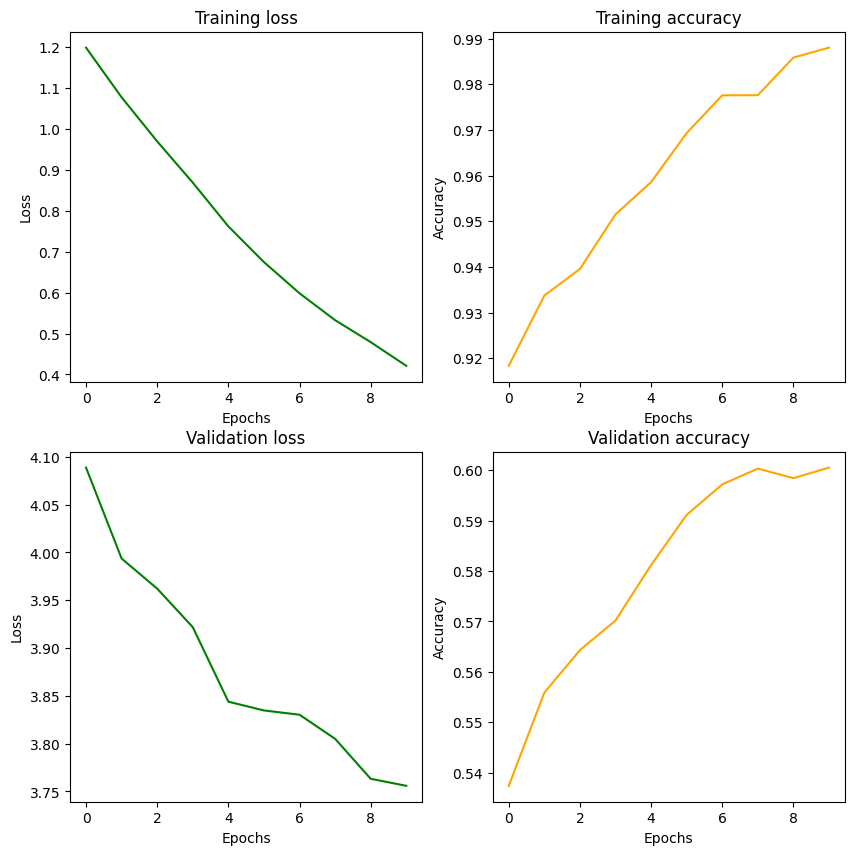

In [ ]:

# Đọc các kết quả huấn luyện mô hình qua từng epoch
train_loss, train_acc = history.history['loss'], history.history['masked_accuracy'] # Đọc thông tin loss, acc trên tập train
val_loss, val_acc = history.history['val_loss'], history.history['val_masked_accuracy'] # Đọc thông tin loss, acc trên tập val

plt.figure(figsize=(10, 10)) # Cài đặt kích thước khung ảnh

plt.subplot(2, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='green') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 2) # Khởi tạo khung ảnh cho training acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Training accuracy') # Hiển thị title của khung ảnh hiện tại là 'Training accuracy'
plt.plot(train_acc, color='orange') # Vẽ đường giá trị accuracy trên tập train qua từng epoch (đường vẽ màu cam)

plt.subplot(2, 2, 3) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='green') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 4) # Khởi tạo khung ảnh cho val acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Validation accuracy') # Hiển thị title của khung ảnh hiện tại là 'Validation accuracy'
plt.plot(val_acc, color='orange') # Vẽ đường giá trị accuracy trên tập val qua từng epoch (đường vẽ màu cam)

plt.show() # Hiển thị 4 khung ảnh nhỏ

In [ ]:
def generate_text(
    generator_model,
    tokenizer,
    input_string
    ):

    encoder_input_string = text_normalize(input_string)
    encoder_input_sequence = tokenizer.texts_to_sequences([encoder_input_string])
    encoder_input_padded_sequence = pad_sequences(encoder_input_sequence, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')[0]
    encoder_input_padded_sequence = np.expand_dims(encoder_input_padded_sequence, axis=0)

    decoder_input_string = '<start>'
    decoder_input_sequence = tokenizer.texts_to_sequences([decoder_input_string])
    decoder_input_padded_sequence = pad_sequences(decoder_input_sequence, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')[0]
    start = decoder_input_padded_sequence[0][tf.newaxis]
    end = decoder_input_padded_sequence[1][tf.newaxis]
    decoder_input_padded_sequence = np.expand_dims(decoder_input_padded_sequence, axis=0)

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(MAX_SEQ_LEN):
        output = tf.transpose(output_array.stack())
        predictions = generator_model((encoder_input_padded_sequence, output), training=False)

        # Select the last token from the `seq_len` dimension.
        predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

        predicted_id = tf.argmax(predictions, axis=-1)

        # Concatenate the `predicted_id` to the output which is given to the
        # decoder as its input.
        output_array = output_array.write(i+1, predicted_id[0])

        if predicted_id == end:
            break

    output = tf.transpose(output_array.stack())
    output_tokens = output.numpy()
    # The output shape is `(1, tokens)`.
    text = tokenizer.sequences_to_texts(output_tokens)[0]  # Shape: `()`.


    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    generator_model([decoder_input_padded_sequence, output[:, :-1]], training=False)
    attention_weights = generator_model.decoder.attention_scores

    return text, output_tokens, attention_weights

In [ ]:
n_sentences = 7
results = ['chú không biết bơi nhỉ']
for idx in range(n_sentences + 1):
    input_str = results[idx]
    text, output_tokens, attention_weights = generate_text(
        transformer,
        tokenizer,
        input_str
    )
    results.append(text.replace('<start>', '').replace('<end>', ''))

print('\n'.join(results))

chú không biết bơi nhỉ
 là việc tốt tất nhiên  
 nhưng còn tốt hơn thế  
 là cố gắng để quên  
 có em thoáng vô lượng  
 không nguyện chúng sinh một  
 lìa vọng huyễn qui chân  
 thắp lửa vô lượng quang  
 sáng soi bảy cửa ngục  
